In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.frameon'] = False

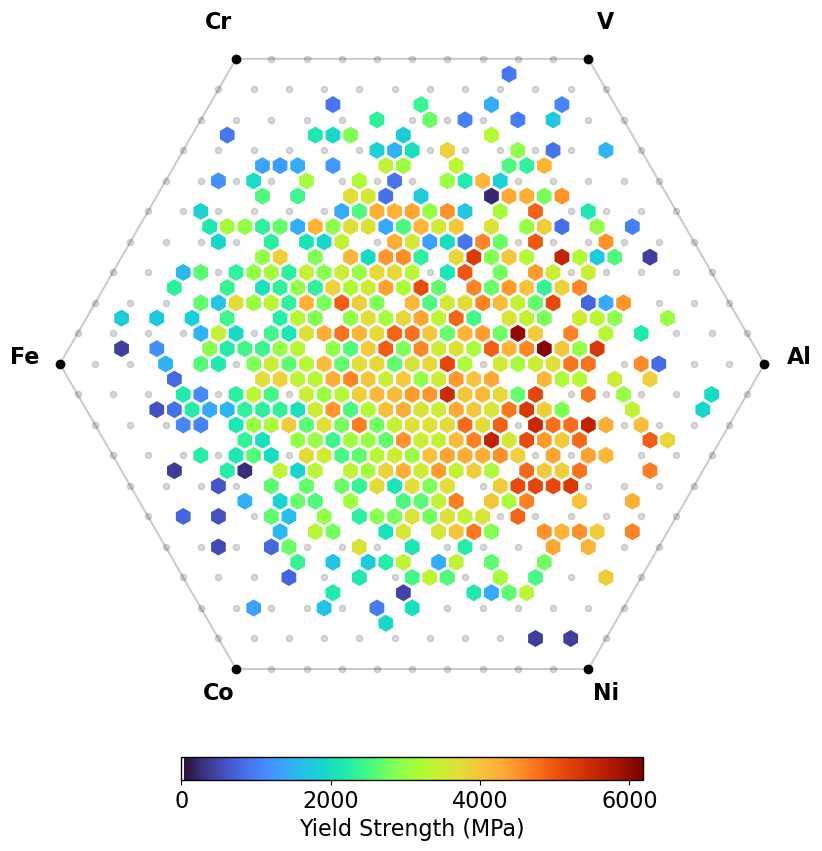

In [6]:
# generate datapoints to form a grid
def generate_grid(n_elements, step=0.1):
    """Generates all combinations summing to 1.0 with discrete steps."""
    compositions = []
    def backtrack(current, remaining):
        if len(current) == n_elements - 1:
            val = round(remaining, 2)
            if 0 <= val <= 1.0: compositions.append(current + [val])
            return
        for val in np.around(np.arange(0, remaining + 0.01, step), 2):
            backtrack(current + [val], remaining - val)
    backtrack([], 1.0)
    return np.array(compositions)

# Elements and Projection Setup
elements = ['Al', 'V', 'Cr', 'Fe', 'Co', 'Ni']
n = len(elements)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
v_x, v_y = np.cos(angles), np.sin(angles)

# Generate and Project Grid
grid = generate_grid(n, step=0.1)
gx, gy = np.dot(grid, v_x), np.dot(grid, v_y)
points = np.vstack((gx, gy)).T
unique_points = np.unique(np.round(points, 8), axis=0)
gx_unique = unique_points[:, 0]
gy_unique = unique_points[:, 1]

# 2. Project Alloy Data
df = pd.read_excel('dataset.xlsx')
df = df[df['Yield Strength (MPa)']>0] # remove the negative (false) yield strength values
data_X = df[elements].values
data_x = np.dot(data_X, v_x) / data_X.sum(axis=1, keepdims=True).flatten()
data_y = np.dot(data_X, v_y) / data_X.sum(axis=1, keepdims=True).flatten()

# Plotting
plt.figure(figsize=(10, 10))

# Hexagon wireframe
plt.plot(np.cos(np.linspace(0, 2*np.pi, n+1)), 
		 np.sin(np.linspace(0, 2*np.pi, n+1)), 'k-', alpha=0.2)

# All datapoints
plt.scatter(gx_unique, gy_unique, color='grey', s=20, alpha=0.3)
scatter = plt.scatter(data_x, data_y, c=df['Yield Strength (MPa)'], marker='h',cmap='turbo', s=180, edgecolors='white')
cbar = plt.colorbar(scatter, label='Yield Strength (MPa)', fraction=0.03, pad=0.05, orientation='horizontal' )
cbar.set_ticks([0, 2000, 4000, 6000], labels=[0, 2000, 4000, 6000])

# Label vertices
for i, label in enumerate(elements):
	plt.text(1.1 * v_x[i], 1.1 * v_y[i], label, ha='center', fontweight='bold', size=16)
	plt.plot(v_x[i], v_y[i], 'ko')

plt.axis('equal')
plt.axis('off')
plt.show()

In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load Data
df = pd.read_excel('dataset.xlsx')
elements = ['Al', 'V', 'Cr', 'Fe', 'Co', 'Ni']

# Filter for Yield Strength > 0
df = df[df['Yield Strength (MPa)'] > 0].copy()

# 2. Grid Generation Logic (Systematic 10% steps)
def generate_grid(n_elements, step=0.1):
    compositions = []
    def backtrack(current, remaining):
        if len(current) == n_elements - 1:
            val = round(remaining, 2)
            if 0 <= val <= 1.0: compositions.append(current + [val])
            return
        for val in np.around(np.arange(0, remaining + 0.01, step), 2):
            backtrack(current + [val], remaining - val)
    backtrack([], 1.0)
    return np.array(compositions)

n = len(elements)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
v_x, v_y = np.cos(angles), np.sin(angles)

# Generate Unique Background Grid Coordinates
grid = generate_grid(n, step=0.1)
gx, gy = np.dot(grid, v_x), np.dot(grid, v_y)
unique_points = np.unique(np.round(np.vstack((gx, gy)).T, 8), axis=0)
gx_u, gy_u = unique_points[:, 0], unique_points[:, 1]

# Project Data
data_X = df[elements].values
data_sums = data_X.sum(axis=1, keepdims=True)
data_x = np.dot(data_X, v_x) / data_sums.flatten()
data_y = np.dot(data_X, v_y) / data_sums.flatten()

# 3. Create Interactive Figure
fig = go.Figure()

# Add Hexagon Boundary
boundary_angles = np.linspace(0, 2 * np.pi, n + 1)
fig.add_trace(go.Scatter(
    x=np.cos(boundary_angles), y=np.sin(boundary_angles),
    mode='lines', line=dict(color='lightgray', width=1),
    showlegend=False, hoverinfo='skip', opacity=0.4
))

# Add Background Grid (Grey Dots)
fig.add_trace(go.Scatter(
    x=gx_u, y=gy_u, mode='markers', 
    marker=dict(color='lightgrey', size=5, opacity=0.4),
    name='10% Step Grid', hoverinfo='skip', showlegend=False,
))

# Prepare Hover Text for Data Points
hover_text = []
for idx, row in df.iterrows():
    composition = "<br>".join([f"{e}: {row[e]*100:.1f}%" for e in elements])
    text = f"<b>Yield Strength: {row['Yield Strength (MPa)']:.1f} MPa</b><br>{composition}"
    hover_text.append(text)

# Add Alloy Data (Colored by Strength)
fig.add_trace(go.Scatter(
    x=data_x, y=data_y, mode='markers',
    marker=dict(
        symbol='hexagon',
        size=12,
        color=df['Yield Strength (MPa)'],
        colorscale='Turbo',
        showscale=True,
        colorbar=dict(title="Yield Strength (MPa)", thickness=20),
        line=dict(width=0.5, color='white')
    ),
    text=hover_text, hoverinfo='text', showlegend=False,
))

# Add Vertex Labels
for i, label in enumerate(elements):
    fig.add_annotation(
        x=1.1 * v_x[i], y=1.1 * v_y[i], text=f"<b>{label}</b>",
        showarrow=False, font=dict(size=14)
    )
    fig.add_trace(go.Scatter(
        x=[v_x[i]], y=[v_y[i]], mode='markers', 
        marker=dict(color='black', size=10), showlegend=False, hoverinfo='skip'
    ))

# Layout Adjustment
fig.update_layout(
    # title=dict(text='Interactive Compositional Space (Hexagon RadViz)', x=0.5),
    xaxis=dict(visible=False, scaleanchor="y", scaleratio=1),
    yaxis=dict(visible=False),
    plot_bgcolor='white', width=800, height=800
)

# Display or Save
fig.show()
fig.write_html("interactive_radviz.html")